# Imports

In [1]:
import json
from functools import reduce
from os import listdir
from os.path import isfile, join
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pylab import rcParams
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Setup

In [2]:
# Set figure size
rcParams['figure.figsize'] = (4, 4)

# Folder for images
Path('img').mkdir(parents=True, exist_ok=True)

# Nice float format
pd.options.display.float_format = "{:,.2f}".format

# Data description

Last year I purchased a Polar watch that tracks my vitals during workouts. I used the [Polar Flow](polar.flow.com) website to obtain a copy of my data. For privacy reasons I shall not be sharing the dataset.

In [3]:
path = './data/'

First, we create a list of files in the download.

In [4]:
files = [f for f in listdir(path) if isfile(join(path, f))]

We shall only consider files containing the string `'training-session'`.

In [5]:
files = [f for f in files if 'training-session' in f]

The number of files under consideration is:

In [6]:
len(files)

284

We loop over each of the files and them to a list.

In [7]:
data = []

for f in files:
    with open(join(path, f)) as f:
        d = json.load(f)
        data.append(d)

We define a function to extract statistics about heart rate measured during the workouts.

In [8]:
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

In [9]:
def extract_hr_info(workout, quantiles):
    
    stats = {'heartRateAvg2': np.nan,
             'heartRateStd': np.nan}    

    for q in quantiles:
        stats[f'heartRateQ' + str(int(q * 100))] = np.nan
    
    # Check if data exists
    try:
        heart_rates = workout['exercises'][0]['samples']['heartRate']    
    except KeyError:
        return stats
     
    # Loop over measurements
    hr_data = []
    for hr in heart_rates:
        
        # Check if actually measured hr
        if 'value' in hr:
            hr_data.append(hr['value'])    

    stats['heartRateAvg2'] = np.mean(hr_data)
    stats['heartRateStd'] = np.std(hr_data)
    
    for q in quantiles:
        stats[f'heartRateQ' + str(int(q * 100))] = np.quantile(hr_data, q)
    
    return stats

We extract the relevant information from the items in the list.

In [10]:
workouts = []

for d in data:
    basic = d['exercises'][0]
    hr = extract_hr_info(workout=d, 
                         quantiles=quantiles)
    
    workouts.append({**basic, **hr})

Finally we create a dataframe containing the workout information.

In [11]:
df = pd.DataFrame(workouts)

# Data structure

We find the following columns in the dataframe.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startTime       284 non-null    object 
 1   stopTime        284 non-null    object 
 2   timezoneOffset  284 non-null    int64  
 3   duration        284 non-null    object 
 4   sport           284 non-null    object 
 5   kiloCalories    283 non-null    float64
 6   heartRate       283 non-null    object 
 7   zones           284 non-null    object 
 8   samples         284 non-null    object 
 9   heartRateAvg2   283 non-null    float64
 10  heartRateStd    283 non-null    float64
 11  heartRateQ1     283 non-null    float64
 12  heartRateQ25    283 non-null    float64
 13  heartRateQ50    283 non-null    float64
 14  heartRateQ75    283 non-null    float64
 15  heartRateQ99    283 non-null    float64
 16  distance        130 non-null    float64
 17  latitude        130 non-null    flo

We remove columns that containt data from features I do not use in my training.

Due to privacy concerns I shan't be extracting longitudinal and latitudinal data.

In [13]:
df = df.drop(['zones', 'samples', 'autoLaps', 
              'laps', 'latitude', 'longitude', 
              'ascent', 'descent'], axis=1)

In [14]:
df.head()

,startTime,stopTime,timezoneOffset,duration,sport,kiloCalories,heartRate,heartRateAvg2,heartRateStd,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,distance,speed
0,2019-05-24T13:18:14.000,2019-05-24T14:58:44.125,120,PT6030.125S,STRENGTH_TRAINING,658.00,"{'min': 72, 'avg': 105, 'max': 136}",104.77,11.28,77.00,99.00,105.00,111.00,132.00,nan,NaN
1,2019-05-04T12:03:34.000,2019-05-04T13:21:38.500,120,PT4684.500S,STRENGTH_TRAINING,373.00,"{'min': 71, 'avg': 99, 'max': 138}",98.65,12.51,74.00,91.00,97.00,106.00,126.00,nan,NaN
2,2019-04-12T12:48:57.000,2019-04-12T12:59:10.750,120,PT613.750S,TREADMILL_RUNNING,62.00,"{'min': 71, 'avg': 97, 'max': 107}",97.07,8.00,72.00,94.00,97.00,104.00,107.00,nan,NaN
3,2019-06-12T13:13:09.000,2019-06-12T13:23:15.500,120,PT606.500S,TREADMILL_RUNNING,71.00,"{'min': 67, 'avg': 105, 'max': 121}",105.24,11.25,67.96,98.00,104.00,118.00,121.00,nan,NaN
4,2019-05-24T14:59:06.000,2019-05-24T15:29:08.750,120,PT1802.750S,TREADMILL_RUNNING,416.00,"{'min': 84, 'avg': 144, 'max': 170}",143.85,18.47,87.00,133.00,146.00,158.00,169.00,nan,NaN


# Missing Values

The watch tracks different information for different workouts. For example when walking it tracks location but when walking on a treadmill it doesn't, hence there is quite a lot of missing data.

In [15]:
missing = (df.isna().sum() / df.shape[0] * 100)
missing.name = 'Percent missing'
missing = missing.to_frame()
missing = missing.sort_values('Percent missing', ascending=False)
missing = missing[missing['Percent missing'] > 0]
np.round(missing, 2)

,Percent missing
distance,54.23
speed,54.23
kiloCalories,0.35
heartRate,0.35
heartRateAvg2,0.35
heartRateStd,0.35
heartRateQ1,0.35
heartRateQ25,0.35
heartRateQ50,0.35
heartRateQ75,0.35


# Transforms

We apply certain transforms to make the data easier to work with. First we convert strings to datetimes.

In [16]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['stopTime'] = pd.to_datetime(df['stopTime'])

We calculate the total duration of each individual workout in minutes.

In [17]:
df['totalTime'] = (df['stopTime'] - df['startTime'])
df['totalTime'] = df['totalTime'].apply(lambda x: round(x.seconds / 60, 2))
df.drop('duration', axis=1, inplace=True)

We extract maximum, average and minimum heart rate values from the `heartRate` column.

In [18]:
df['heartRateMax'] = df['heartRate'].apply(lambda x: x['max'] if isinstance(x, dict) else np.nan)
df['heartRateAvg'] = df['heartRate'].apply(lambda x: x['avg'] if isinstance(x, dict) else np.nan)
df['heartRateMin'] = df['heartRate'].apply(lambda x: x['min'] if isinstance(x, dict) else np.nan)
df.drop('heartRate', axis=1, inplace=True)

We assume that if there is no `distance` then the workout was indoors:

In [19]:
df['indoors'] = df['distance'].apply(lambda x: True if pd.isnull(x) else False)
df = df.drop(['distance', 'speed'], axis=1)

We are going to map sports to different `activityType`'s. We will map strength training to `True` and cardiovascular work to `False`.

In [20]:
def sport_to_activity_type(x):
    if 'strength' in x.lower():
        return True
    else:
        return False

In [21]:
df['activityType'] = df['sport'].apply(sport_to_activity_type)

We extract a list of unique `sport` values:

In [22]:
sports = sorted(list(df['sport'].unique()))

We reorder the alphabetically

In [23]:
order = sorted(df.columns.to_list())

In [24]:
df = df[order]

We check if there are any more `NaN`'s in the data.

In [25]:
df.isna().sum()

activityType      0
heartRateAvg      1
heartRateAvg2     1
heartRateMax      1
heartRateMin      1
heartRateQ1       1
heartRateQ25      1
heartRateQ50      1
heartRateQ75      1
heartRateQ99      1
heartRateStd      1
indoors           0
kiloCalories      1
sport             0
startTime         0
stopTime          0
timezoneOffset    0
totalTime         0
dtype: int64

There is one row with `NaN`'s. This might due to my watch having little battery left to make the measurements.

In [26]:
df = df.dropna()

We proceed to sort the data with the latest workouts at the top of the dataframe.

In [27]:
sort_cols = ['startTime','startTime']
df = df.sort_values(sort_cols, ascending=False)
df = df.reset_index(drop=True)

We verify that the datatypes are correct.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   activityType    283 non-null    bool          
 1   heartRateAvg    283 non-null    float64       
 2   heartRateAvg2   283 non-null    float64       
 3   heartRateMax    283 non-null    float64       
 4   heartRateMin    283 non-null    float64       
 5   heartRateQ1     283 non-null    float64       
 6   heartRateQ25    283 non-null    float64       
 7   heartRateQ50    283 non-null    float64       
 8   heartRateQ75    283 non-null    float64       
 9   heartRateQ99    283 non-null    float64       
 10  heartRateStd    283 non-null    float64       
 11  indoors         283 non-null    bool          
 12  kiloCalories    283 non-null    float64       
 13  sport           283 non-null    object        
 14  startTime       283 non-null    datetime64[ns]
 15  stopTi

# Analysis

Given that we have produced a clean dataset we can proceed to analyse a few aspects.

## Time span

The date of the first workout is:

In [29]:
str(df['startTime'].min())

'2019-02-20 20:46:35'

The date of the last workout is:

In [30]:
str(df['startTime'].max())

'2020-03-29 21:50:21'

Workouts measured:

In [31]:
len(df)

283

## Descriptive statistics

In [32]:
df.drop('timezoneOffset', axis=1).describe()

,heartRateAvg,heartRateAvg2,heartRateMax,heartRateMin,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,heartRateStd,kiloCalories,totalTime
count,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00,283.00
mean,105.19,105.24,128.34,76.74,80.61,98.24,105.55,112.64,125.84,10.52,315.98,42.83
std,11.87,11.86,18.25,8.99,8.40,10.69,12.26,14.36,18.06,4.46,218.75,29.65
min,82.00,81.98,93.00,53.00,54.00,77.00,82.00,87.00,92.00,2.96,29.00,5.00
25%,96.00,96.42,115.00,70.00,75.00,91.00,97.00,102.00,113.00,7.58,121.50,15.92
50%,103.00,103.42,125.00,77.00,80.00,97.00,104.00,111.00,123.00,10.00,277.00,36.45
75%,111.00,111.26,138.50,83.00,86.00,103.00,112.00,119.00,135.00,12.25,441.50,65.29
max,148.00,148.35,178.00,99.00,107.00,146.00,151.00,160.00,177.00,27.10,"1,067.00",172.73


## Kilocalories burned in total

First we count the total `kiloCalories` I burned during the period in question.

In [33]:
total_calories = df['kiloCalories'].sum()
print(total_calories)

89421.0


We convert this number to kilograms of body fat.
According to [this article](https://www.livestrong.com/article/304137-how-many-calories-per-kilogram-of-weight/) it equates to

In [34]:
round(total_calories / 7700, 2)

11.61

## Kilocalories burned by sport

In [35]:
by_sport = df[['kiloCalories', 'sport']].groupby('sport', as_index=False)
by_sport = by_sport.sum()
by_sport['sport'] = by_sport['sport'].apply(lambda x: x.lower())
by_sport['kiloCalories'] = by_sport['kiloCalories'].astype(int)
by_sport = by_sport.rename(columns={'kiloCalories': 'total kilocalories'})
by_sport = by_sport.sort_values('total kilocalories', ascending=False)
by_sport

,sport,total kilocalories
4,walking,33080
2,strength_training,31547
3,treadmill_running,19825
0,cycling,4029
1,running,940


## Kilocalories burned over time

Next we produce a plot of `kiloCalories` burned over a two month period in 2019. First we extract the relevant data.

In [36]:
start = pd.to_datetime('2019-04-1') 
stop = pd.to_datetime('2019-06-1')

daily = df[['startTime', 'kiloCalories']]
mask = (daily['startTime'] >= start) & (daily['startTime'] < stop)
daily = daily[mask]
daily['startTime'] = daily['startTime'].dt.date
daily = daily.groupby('startTime', as_index=False)
daily = daily.sum()
daily = daily.sort_values('startTime', ascending=False)
daily['startTime'] = pd.to_datetime(daily['startTime'])
daily = daily.reset_index(drop=True)

We create a dataframe with all the dates to perform a left join and fill the `NaN`'s with zeroes.

In [37]:
dates = pd.date_range(start, stop)
dates = dates.to_frame()
dates = dates.reset_index(drop=True)
dates.columns = ['startTime']

In [38]:
daily = pd.merge(dates, daily, on='startTime', how='left')
daily = daily.fillna(0)

Finally we produce the figure:

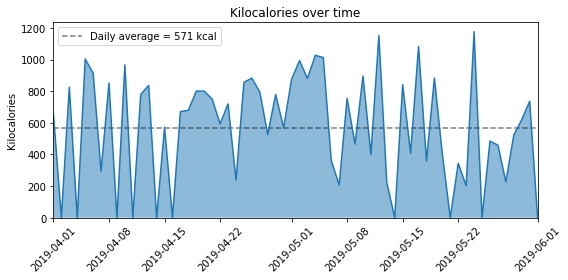

In [39]:
width = 800
height = 400
dpi = 100

plt.figure(figsize=(width/dpi, height/dpi))
plt.plot(daily['startTime'], daily['kiloCalories'])

plt.fill_between(x=daily['startTime'], 
                 y1=0, 
                 y2=daily['kiloCalories'], 
                 alpha=1/2)

daily_avg = daily['kiloCalories'].mean()

plt.hlines(xmin=daily['startTime'].min(),
           xmax=daily['startTime'].max(),
           y=daily_avg,
           linestyle='dashed',
           label=f'Daily average = {round(daily_avg)} kcal',
           alpha=1/2)

plt.title('Kilocalories over time')
plt.xticks(rotation=45, horizontalalignment='center')
plt.xlim(daily['startTime'].min(), daily['startTime'].max())
plt.ylim(0, daily['kiloCalories'].max() * 1.05)
plt.ylabel('Kilocalories')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./img/kilocalories_ts.png')
plt.show()

# Kilocalories by intensity

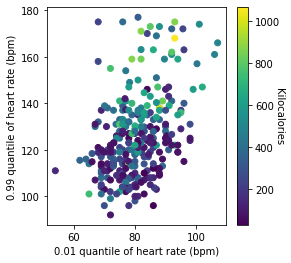

In [40]:
plt.scatter(df['heartRateQ1'], df['heartRateQ99'], c=df['kiloCalories'])
plt.xlabel('0.01 quantile of heart rate (bpm)')
plt.ylabel('0.99 quantile of heart rate (bpm)')

cbar = plt.colorbar()
cbar.set_label('Kilocalories', rotation=270)
plt.savefig('./img/intensity_scatter.png')
plt.show()

## Workouts by sport

We check how many workouts I completed.

In [41]:
stats = df[['sport', 'startTime']]
stats = stats.groupby(['sport'], as_index=False)
stats = stats.count()
stats = stats.rename(columns={'sport': 'Sport', 
                              'startTime': 'Count'})
stats = stats.sort_values('Count', ascending=False)
stats.head()

,Sport,Count
4,WALKING,105
3,TREADMILL_RUNNING,90
2,STRENGTH_TRAINING,62
0,CYCLING,24
1,RUNNING,2


## By hour of day

We count workouts by hour of day.

In [42]:
by_hour = df[['startTime', 'sport']].copy()
by_hour['startHour'] = by_hour['startTime'].dt.hour
by_hour = by_hour.drop('startTime', axis=1)
by_hour = by_hour.groupby('startHour', as_index=False)
by_hour = by_hour.count()

all_hours = pd.DataFrame(range(0, 24), columns=['startHour'])

by_hour = pd.merge(all_hours, by_hour, how='left')
by_hour = by_hour.fillna(0)
by_hour = by_hour.sort_values('startHour')
by_hour = by_hour.rename(columns={'startHour': 'Hour of day', 
                                 'sport': 'Total workouts'})

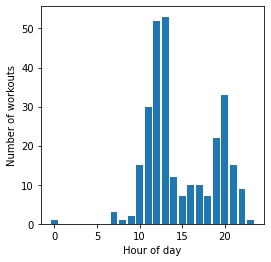

In [43]:
plt.bar(by_hour['Hour of day'], by_hour['Total workouts'])
plt.ylabel('Number of workouts')
plt.xlabel('Hour of day')
plt.savefig('./img/workouts_by_hour_of_day.png')
plt.show()

## By day of week

We count workouts by day of week.

In [44]:
by_day = df[['startTime', 'sport']].copy()
by_day['Day of week'] = pd.to_datetime(by_day['startTime']).dt.day_name()
by_day['Day number'] = pd.to_datetime(by_day['startTime']).dt.dayofweek
by_day = by_day.groupby(['Day of week', 'Day number'], as_index=False)
by_day = by_day.count()
by_day = by_day.drop('startTime', axis=1)
by_day = by_day.sort_values('Day number')
by_day = by_day.rename(columns={'sport': 'Total Workouts'})

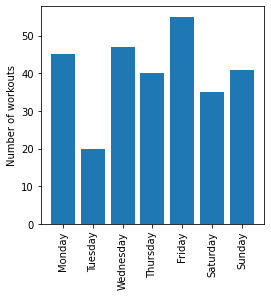

In [45]:
plt.bar(by_day['Day of week'], by_day['Total Workouts'])
plt.xticks(rotation=90)
plt.ylabel('Number of workouts')
plt.savefig('./img/workouts_by_day_of_week.png')
plt.show()

## Scatter plot of walks data

We plot `totalTime` versus `kiloCalories`. As can be seen their seems to exist a linear relationship between the two.

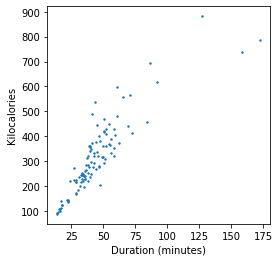

In [46]:
walking = df[df['sport'] == 'WALKING']
plt.scatter(walking['totalTime'], walking['kiloCalories'], s=2)
plt.xlabel('Duration (minutes)')
plt.ylabel('Kilocalories')
plt.savefig('./img/walks_kilocalories_vs_time.png')
plt.show()

We plot `heartRateAvg` against `kiloCalories`. Again we see a linear relationship although there are a couple of outliers

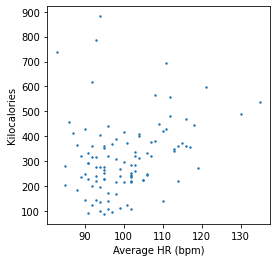

In [47]:
walking = df[df['sport'] == 'WALKING']
plt.scatter(walking['heartRateAvg'], walking['kiloCalories'], s=2)
plt.ylabel('Kilocalories')
plt.xlabel('Average HR (bpm)')
plt.savefig('./img/walks_kilocalories_vs_avg_hr.png')
plt.show()

# Regression

## Data preparation

Now we proceed to build a regression model to predict `kiloCalories` burned during a workout. First we create a subset of the original data.

In [48]:
reg_df = df[['kiloCalories', 'totalTime', 
             'heartRateQ99', 'activityType', 
             'indoors', 'sport']].copy()

We remove the rows where `sport` is `RUNNING` because there were only two workouts recorded during the period in question.

In [49]:
reg_df = reg_df[reg_df['sport'] != 'RUNNING']
reg_df = reg_df.drop('sport', axis=1)

We convert binary features to integers for statsmodels.

In [50]:
reg_df['indoors'] = reg_df['indoors'].astype(int)
reg_df['activityType'] = reg_df['activityType'].astype(int)

### Outliers

The data is cleansed of outliers using interquartile range.

In [51]:
def is_outlier_iqr(series, k=1.5):
    """
    Check if value is an outlier
    using interquartile range.
    """
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)        
    iqr = q3 - q1
    is_outlier = (series <= q1 - k * iqr) | (q3 + k * iqr <= series)
    
    return is_outlier

In [52]:
time_mask = is_outlier_iqr(series=reg_df['totalTime'])
kcal_mask = is_outlier_iqr(series=reg_df['kiloCalories'])
hr_mask = is_outlier_iqr(series=reg_df['heartRateQ99'])

In [53]:
reg_df = reg_df[~(time_mask | kcal_mask | hr_mask)]

### Transforms

We apply the log transform to `heartRateQ99` hoping to reduce variance.

In [54]:
reg_df['heartRateQ99'] = np.log(reg_df['heartRateQ99'])

### Histograms of features

We proceed to visualize histograms of each of the variables.

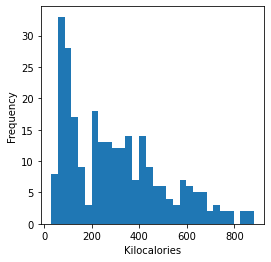

In [55]:
plt.hist(reg_df['kiloCalories'], bins=30)
plt.xlabel('Kilocalories')
plt.ylabel('Frequency')
plt.savefig('./img/kilocalories_histogram.png')
plt.show()

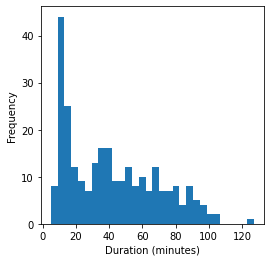

In [56]:
plt.hist(reg_df['totalTime'], bins=30)
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.savefig('./img/duration_histogram.png')
plt.show()

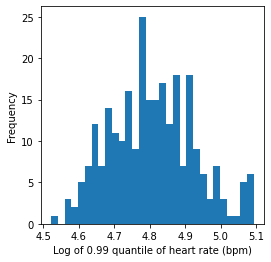

In [57]:
plt.hist(reg_df['heartRateQ99'], bins=30)
plt.xlabel('Log of 0.99 quantile of heart rate (bpm)')
plt.ylabel('Frequency')
plt.savefig('./img/average_hr_histogram.png')
plt.show()

### Relationship with target variable

In [58]:
activity = [0, 1]
activity_type = ['Cardio', 'Strength']

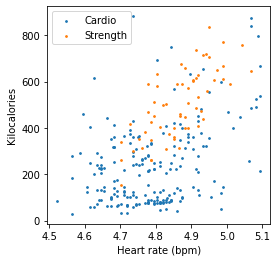

In [59]:
for val,name in zip(activity,activity_type):
    tmp = reg_df[reg_df['activityType'] == val]
    plt.scatter(tmp['heartRateQ99'],
                tmp['kiloCalories'],
                s=3, 
                label=name)

plt.xlabel('Heart rate (bpm)')    
plt.ylabel('Kilocalories')
plt.legend(loc='best')
plt.savefig('./img/time_vs_kilocalories_scatter.png')
plt.show()

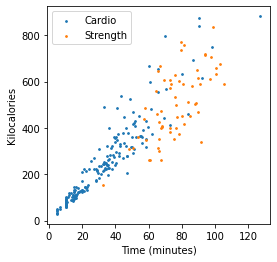

In [60]:
for val,name in zip(activity,activity_type):
    tmp = reg_df[reg_df['activityType'] == val]
    plt.scatter(tmp['totalTime'], 
                tmp['kiloCalories'],
                s=3, 
                label=name)
    
plt.xlabel('Time (minutes)')    
plt.ylabel('Kilocalories')    
plt.legend(loc='best')
plt.savefig('./img/time_vs_kilocalories_scatter.png')
plt.show()

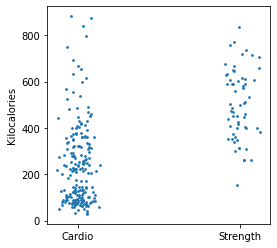

In [61]:
plt.scatter(reg_df['activityType'] + np.random.normal(scale=1/20, size=len(reg_df)), 
            reg_df['kiloCalories'], s=3)
plt.ylabel('Kilocalories')
plt.xticks(ticks=[0, 1], labels=['Cardio', 'Strength'])
plt.savefig('./img/activity_type_vs_kilocalories_scatter.png')
plt.show()

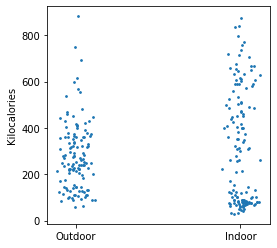

In [62]:
plt.scatter(reg_df['indoors'] + np.random.normal(scale=1/20, size=len(reg_df)), 
            reg_df['kiloCalories'], s=3)
plt.ylabel('Kilocalories')
plt.xticks(ticks=[0, 1], labels=['Outdoor', 'Indoor'])
plt.savefig('./img/indoors_type_vs_kilocalories_scatter.png')
plt.show()

## Correlation

We inspect the correlation matrix to check for multicollinearity. It should be noted that the correlation between `kiloCalories` and `totalTime` is quite high and this to be expected.

In [63]:
C = reg_df.corr(method='pearson')
C = C.style.background_gradient(cmap='coolwarm')
C = C.set_precision(2)
C = C.set_table_attributes('style="font-size: 15px"')
C

,kiloCalories,totalTime,heartRateQ99,activityType,indoors
kiloCalories,1.00,0.92,0.50,0.55,0.09
totalTime,0.92,1.00,0.28,0.69,0.09
heartRateQ99,0.50,0.28,1.00,0.27,0.37
activityType,0.55,0.69,0.27,1.00,0.52
indoors,0.09,0.09,0.37,0.52,1.00


## Multicollinearity

We inspect the respect variance inflation factors and are happy to see that all are below 10.

In [64]:
tmp = reg_df.drop(['kiloCalories'], axis=1)

vifs = []
for i in range(tmp.shape[1]):
    vif = variance_inflation_factor(tmp.to_numpy(), i)
    vifs.append(round(vif, 2))
    
vifs = pd.DataFrame(vifs, index=tmp.columns, columns=['VIF'])
vifs = vifs.sort_values('VIF', ascending=False)
vifs = vifs.style.background_gradient(cmap='coolwarm')
vifs = vifs.set_precision(2)
vifs = vifs.set_table_attributes('style="font-size: 15px"')

vifs

,VIF
totalTime,7.74
heartRateQ99,6.97
activityType,4.13
indoors,3.63


## Model

The model we shall fit is:

$c_{i} = \beta_{1} t_{i} + \beta_{2} \ln{h_{i}} + \beta_{3}a_{i} + \beta_{4}d_{i}+ \varepsilon_{i}$

Where:
* $c_{i}$ - The $i$-th `kiloCalories` value.
* $t_{i}$ - The $i$-th `totalTime` value.
* $h_{i}$ - The $i$-th `heartRateQ99` value.
* $a_{i}$ - The $i$-th `activityType` value.
* $d_{i}$ - The $i$-th `indoors` value.

And of course $\varepsilon_{i}$ is a iid normal error.

We create the `X` and `y` dataframes.

In [65]:
y = reg_df[['kiloCalories']]
X = reg_df.drop(['kiloCalories'], axis=1)

In [66]:
X.head()

,totalTime,heartRateQ99,activityType,indoors
0,33.33,4.74,0,0
1,46.52,4.88,0,0
2,45.15,4.79,0,0
3,47.65,4.82,0,0
4,39.67,4.95,0,0


In [67]:
y.head()

,kiloCalories
0,245.00
1,401.00
2,336.00
3,380.00
4,358.00


We create the model using all of the prepared variables:

In [68]:
mdl = sm.OLS(y, X)
res = mdl.fit()

residuals = res.resid

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           kiloCalories   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              1528.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):                   1.02e-179
Time:                        17:20:55   Log-Likelihood:                         -1513.0
No. Observations:                 265   AIC:                                      3034.
Df Residuals:                     261   BIC:                                      3048.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [69]:
with open('mdl_results.txt', 'w') as f:
    text = res.summary().as_text()
    f.write(text)

## Model evaluation

It should be noted that the model achieved `R^2 = 0.96` and that the Durbin-Watson test statistic is slightly less than 2.

### Visual inspection

We proceed to inspect the residuals of the model. First we view the histogram of the residuals.

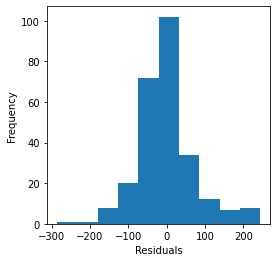

In [70]:
plt.hist(residuals)
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.savefig('./img/mdl_residuals.png')
plt.show()

The next plot is a qqplot created to visually inspect the normality of the residuals.

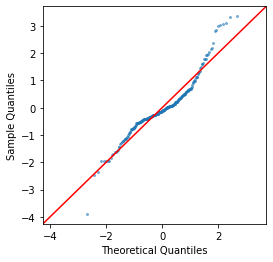

In [71]:
plt.figure()
ax = plt.gca()
qqplot(res.resid, ax=ax, color='#1f77b4', markersize=2, line='45', fit=True, alpha=1/2)
plt.savefig('./img/mdl_qq.png')
plt.show()

The third plot we make is a plot of the standardized residuals to check for homoskedasticity.

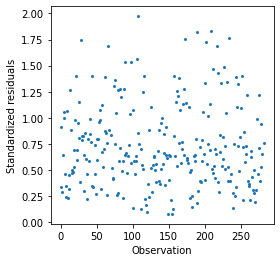

In [72]:
residuals_std = np.sqrt(np.abs((residuals - np.mean(residuals)) / np.std(residuals)))
plt.plot(residuals_std, 'o', markersize=2)
plt.xlabel('Observation')
plt.ylabel('Standardized residuals')
plt.savefig('./img/mdl_residuals_std.png')
plt.show()

Finally we compare the predicted `kiloCalories` with the actual values.

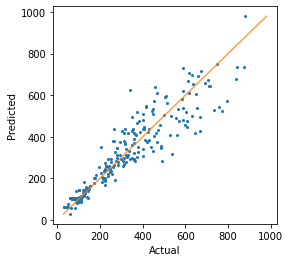

In [73]:
y_pred = res.predict(X)
y_pred = y_pred.to_numpy().reshape(len(y_pred))
y_true = y.to_numpy().reshape(len(y),)

m = np.min(np.hstack([y_true, y_pred]))
M = np.max(np.hstack([y_true, y_pred]))

x = np.linspace(m, M, len(y))
plt.plot(y_true, y_pred, 'o', markersize=2)
plt.plot(x,x, alpha=3/4)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.savefig('./img/mdl_predicted_vs_actual.png')
plt.show()

The next step is to take a look at the datapoints with the biggest error.

In [74]:
X['totalTime'] = reg_df['totalTime']
X['heartRateQ99'] = reg_df['heartRateQ99']
X['y_true'] = y
X['y_pred'] = y_pred
X['e'] = X['y_true'] - X['y_pred']
X = X.sort_values('e', ascending=False)

In [75]:
X.head()

,totalTime,heartRateQ99,activityType,indoors,y_true,y_pred,e
209,79.25,4.99,1,1,770.00,526.07,243.93
190,66.65,4.99,1,1,667.00,426.37,240.63
234,65.75,5.07,1,1,644.00,418.83,225.17
173,69.65,5.09,0,1,795.00,571.49,223.51
28,43.33,5.09,0,0,536.00,315.08,220.92


### Statistical tests

We now move on to performing statistical tests for normality and homoskedasticity.

In [76]:
def hypothesis_decision(x, alpha=0.05):
    if x < alpha:
        return 'Reject null hypothesis'
    else:
        return 'Fail to reject null hypothesis'

First we carry out the Shapiro-Wilks test for normality. The hypotheses are:

$H_{0} :$ Data comes from a normal distribution.

$H_{1} :$ Data does not come from a normal distribution.

In [77]:
_,shapiro_pval = shapiro(residuals)

The second test we perform is the Breusch-Pagan for homoscedasticity. The hypotheses are:

$H_{0} :$ Homoscedasticity.

$H_{1} :$ Lack of homoscedasticity / Heteroskedasticity.

In [78]:
_,_,_,breusch_pval = het_breuschpagan(residuals, X)

We summarize the outcomes of the tests in a nice table.

In [79]:
pvalues = [shapiro_pval, breusch_pval]
name = ['Shapiro-Wilks', 'Breusch-Pagan',]
null_hyp = ['Normality', 'Heteroskedasticity']

tests = pd.DataFrame([name, null_hyp, pvalues], 
                     index=['Name', 'Null Hypothesis', 'P-value'])

tests = tests.transpose()
tests['Decision'] = tests['P-value'].apply(hypothesis_decision)
tests

,Name,Null Hypothesis,P-value,Decision
0,Shapiro-Wilks,Normality,0.00,Reject null hypothesis
1,Breusch-Pagan,Heteroskedasticity,0.00,Reject null hypothesis


# Estimated model

The estimated model is:

\begin{equation}
c = 7.91t - 5.44\ln{h} - 121.90a + 48.12d 
\end{equation}

Where:
* $c$ denotes `kiloCalories`.
* $t$ denotes` totalTime`.
* $h$ denotes `heartRateQ99`.
* $a$ denotes `activityType`.
* $d$ denotes `indoors`.

# Summary

* I downloaded data generated by my Polar watch that tracks `heart rate` and estimates burned `kilocalories` during workouts.

* The data came in the form of `.json` files which were read, transformed and cleaned with `pandas`. 

* The clean dataset contains `283` workouts over a nearly one year period. 

* After further transforming the data, I find that the `duration` of a workout and `kilocalorie`s burned have a `0.92` correlation. 

* A linear regression model was built using `statsmodels` to predict the total `kilocalorie` expenditure.

* Variables in the model are the `duration` of the session, the `99 quantile of heart rate`, the `activity` type and whether the workout is `indoors`.

* The model achieves an adjusted uncentered `R^2` of `0.958`.

* The estimated formula is: `calories = 7.91 * time - 5.44 * log(heart_rate) - 121.90 * activity_type + 48.12 * indoors`.

* All of the variables are statistically significant.

* The model has a tendency to underpredict long workouts.
* The residuals fail statisticall tests for normality and homoskedasticity.